In [14]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

SAVE_PATH_1 = "./data1"
MP4_PATH = r"E:\MS_ExperimentData\mp4"
LOCAL_FIG_PATH = "./PCT_C_figs"
PCT_C_PATH = r"F:\c-doc\PJT_phaseLag_enhance_phase_seperation\figs"

In [15]:
omegaMins = 0.1
phaseLagA0_1 = [0.6* np.pi]
randomSeed = 8
strengthLambda = 0.15 * 32 * 2 * 2
distanceD0 = 1
deltaOmega = 1
boundaryLength = 7
agnetsCount = 1000
halfAgentsNum = agnetsCount // 2
Homega = np.block([
    [np.ones((halfAgentsNum, halfAgentsNum)), np.zeros((halfAgentsNum, halfAgentsNum))],
    [np.zeros((halfAgentsNum, halfAgentsNum)), np.ones((halfAgentsNum, halfAgentsNum))]
])

---
# Load StateAnalysis

---
# Load Last State

In [16]:
lastStatePath = (
    f"./last_state/PhaseLagPatternFormation(strengthK=19.200,distanceD0=1.000,phaseLagA0=1.885,boundaryLength=7.0,speedV=3.0,freqDist='uniform',omegaMin=0.100,deltaOmega=1.000,agentsNum=1000,dt=0.00).h5"
)

totalPositionX = pd.read_hdf(lastStatePath, key="positionX")
totalPhaseTheta = pd.read_hdf(lastStatePath, key="phaseTheta")


modelNums = totalPositionX.shape[0] // (halfAgentsNum * 2)

totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)


positionXs, phaseThetas= {}, {}

if isinstance(omegaMins, (int, float)):
    omegaMins = np.array([round(omegaMins, 2)])
else:
    omegaMins = np.round(omegaMins, 2)

phaseLagA0_1 = np.round(phaseLagA0_1, 2)

for idx, (omegaMin, phaseLagA0) in enumerate(product(omegaMins, phaseLagA0_1)):
    positionXs[(omegaMin, phaseLagA0)] = totalPositionX[idx]
    phaseThetas[(omegaMin, phaseLagA0)] = totalPhaseTheta[idx]


---
# Snapshot

---
# Center Scatter

In [17]:
model1 = PhaseLagPatternFormation(
    strengthK=19.2, distanceD0=1, boundaryLength=7,
    phaseLagA0=0.6 * np.pi,  initPhaseTheta=np.zeros(1000),
    omegaMin=0.1, deltaOmega=1,
    agentsNum=1000, savePath=SAVE_PATH_2, dt=0.001,
    tqdm=True, overWrite=True, randomSeed=8, shotsnaps=10
)
sa1 = StateAnalysis(model1)

model2 = PhaseLagPatternFormation(
    strengthK=19.2, distanceD0=1, boundaryLength=7,
    phaseLagA0=0.6 * np.pi, initPhaseTheta=np.zeros(1000),
    omegaMin=0.1, deltaOmega=1,
    agentsNum=1000, savePath=SAVE_PATH_2, dt=0.001,
    tqdm=True, overWrite=True, randomSeed=8, shotsnaps=10
)
sa2 = StateAnalysis(model2)

length = sa1.totalPhaseTheta.shape[0]
rawClass1, rawClass2 = (
    np.concatenate([np.ones(500), np.zeros(500)]).astype(bool), 
    np.concatenate([np.zeros(500), np.ones(500)]).astype(bool)
)
tRanges = np.arange(length).repeat(1000)
class1 = np.concatenate([rawClass1] * length)
class2 = np.concatenate([rawClass2] * length)

tsCentersList = []
totalCentersList = []

for sa in [sa1, sa2]:

    model = sa.model
    tsCenters = []

    for i in tqdm(range(1, length, 1)):
        positionx = sa.totalPositionX[i, :, 0]
        positiony = sa.totalPositionX[i, :, 1]
        pointTheta = (sa.totalPhaseTheta[i, :] - sa.totalPhaseTheta[i-1, :]) / model.dt
        # 避免除以0或太小，加入一个小常数eps
        eps = 1e-8
        pointTheta = np.where(np.abs(pointTheta) < eps, eps, pointTheta)



        center = np.array([
            positionx - model.speedV * model.dt / pointTheta * np.sin(sa.totalPhaseTheta[i, :]),
            positiony + model.speedV * model.dt / pointTheta * np.cos(sa.totalPhaseTheta[i, :])
        ]).T

        tsCenters.append(center)

    tsCenters.insert(0, tsCenters[0])
    totalCenters = np.array(tsCenters)
    tsCenters = np.concatenate(tsCenters)
    tsCenters = np.mod(tsCenters, model.boundaryLength)
    totalCenters = np.mod(totalCenters, model.boundaryLength)

    tsCentersList.append(tsCenters)
    totalCentersList.append(totalCenters)


  0%|          | 0/8001 [00:00<?, ?it/s]

  0%|          | 0/8001 [00:00<?, ?it/s]

AttributeError: 'AxesSubplot' object has no attribute 'flatten'

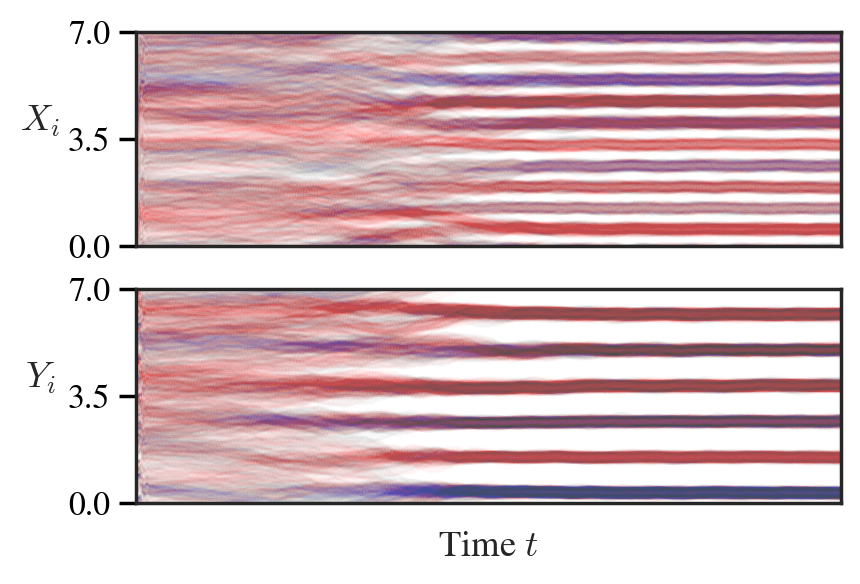

In [ ]:
import matplotlib.patches as patches
class1Color = "#FF4B4E"
class2Color = "#414CC7"

s = 0.2
alpha = 0.004

fig, axs = plt.subplots(1, 1, figsize=(10, 3.2 * 2))
step = 5
idx_class1 = np.where(class1)[0][::step]
idx_class2 = np.where(class2)[0][::step]

ax11 = plt.subplot(421)
plt.scatter(tRanges[idx_class2], tsCentersList[0][idx_class2, 0], s=s, alpha=alpha, color=class2Color)
plt.scatter(tRanges[idx_class1], tsCentersList[0][idx_class1, 0], s=s, alpha=alpha, color=class1Color)
plt.xticks([])
plt.ylabel(r"$X_i$", rotation=0, labelpad=10)
ax11.set_xlim(0, np.max(tRanges))

ax21 = plt.subplot(423)
plt.scatter(tRanges[idx_class2], tsCentersList[0][idx_class2, 1], s=s, alpha=alpha, color=class2Color)
plt.scatter(tRanges[idx_class1], tsCentersList[0][idx_class1, 1], s=s, alpha=alpha, color=class1Color)
plt.xticks([])
plt.ylabel(r"$Y_i$", rotation=0, labelpad=10)
plt.xlabel(r"Time $t$")
ax21.set_xlim(0, np.max(tRanges))

for ax in [ax11, ax21]:
    ax.set_ylim(0, 7)
    ax.set_yticks([0, 3.5, 7])
for ax in axs.flatten():
    ax.set_xlim(0, 800)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', length=3)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
ax11Pos = ax11.get_position()
ax11Pos.y0 = ax11Pos.y0 - 0.04
ax11Pos.y1 = ax11Pos.y1 - 0.04
ax11.set_position(ax11Pos)
ax21Pos = ax21.get_position()
ax21Pos.y0 -= 0.04
ax21Pos.y1 -= 0.04
ax21.set_position(ax21Pos)


alpha = 0.004
height = 17.7
width = 930
rectangle = patches.Rectangle((-110, -9), width, height, linewidth=1, alpha=alpha,
                              edgecolor=None, facecolor='grey', clip_on=False, zorder=0)
ax11.add_patch(rectangle)
rectangle = patches.Rectangle((-110, -9), width, height, linewidth=1, alpha=alpha,
                              edgecolor=None, facecolor='grey', clip_on=False, zorder=0)
ax12.add_patch(rectangle)

plt.savefig(f"{LOCAL_FIG_PATH}/centersScatterXY.png", dpi=300, bbox_inches="tight")

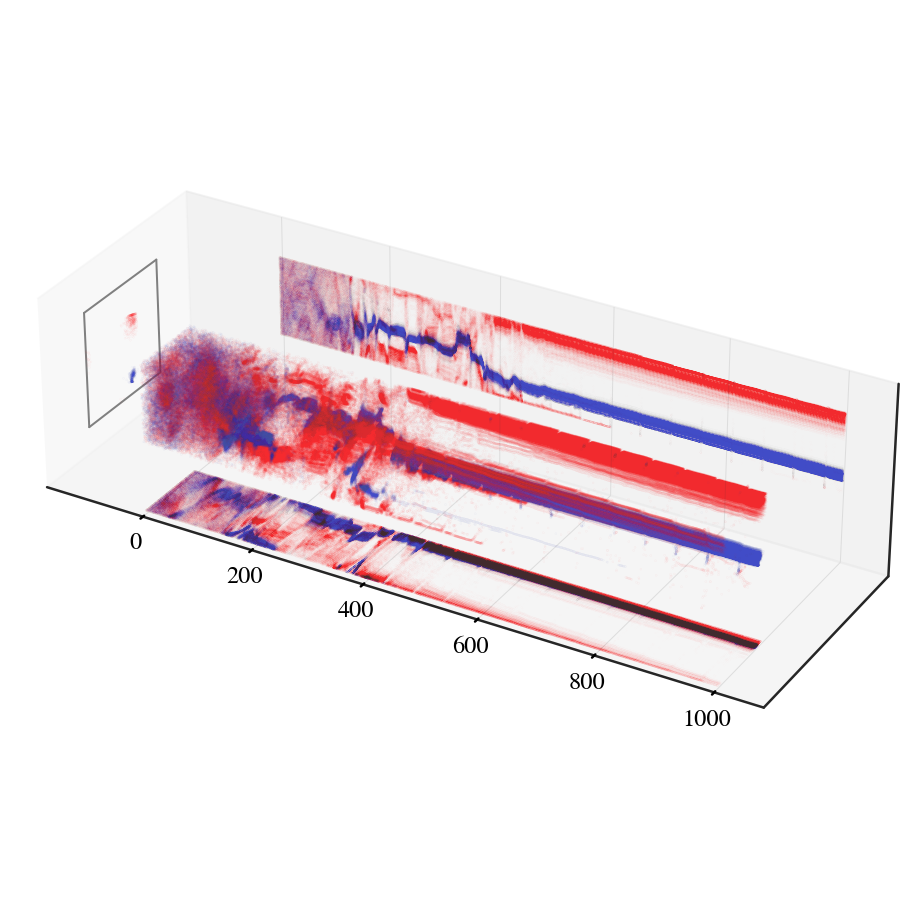

In [14]:
color = ["#FF2A2E"] * 500 + ["#414CC7"] * 500
colors = np.array(color * (tRanges.shape[0] // 1000))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
lowLim = -6
backLim = 20
alpha1 = 0.1
alpha2 = 0.01
s = 0.01

ax.scatter(tRanges, tsCenters[:, 0], tsCenters[:, 1], s=s, alpha=alpha1, c=colors)

bottom = -100

# F16623, 49B2B2
ax.scatter(bottom, totalCenters[-1, rawClass1, 0], totalCenters[-1, rawClass1, 1], s=s, alpha=alpha1, color="#FF2A2E")
ax.scatter(bottom, totalCenters[-1, rawClass2, 0], totalCenters[-1, rawClass2, 1], s=s, alpha=alpha1, color="#414CC7")
ax.plot3D([bottom, bottom], [0, 0], [10, 0], 'gray', lw=1)
ax.plot3D([bottom, bottom], [10, 10], [10, 0], 'gray', lw=1)
ax.plot3D([bottom, bottom], [0, 10], [0, 0], 'gray', lw=1)
ax.plot3D([bottom, bottom], [0, 10], [10, 10], 'gray', lw=1)

ax.scatter(tRanges, tsCenters[:, 0], np.ones_like(tsCenters[:, 1]) * lowLim, s=s, alpha=alpha2, c=colors)

ax.scatter(tRanges, np.ones_like(tsCenters[:, 0]) * backLim, tsCenters[:, 1], s=s, alpha=alpha2, c=colors)

ax.set_ylim(0, backLim)
ax.set_zlim(lowLim, 10)
ax.set_box_aspect([3, 1, 1 / backLim * (10 - lowLim)])
ax.set_yticks([], [])
ax.set_zticks([], [])
ax.set_xticks(ax.get_xticks()[1:-1])

plt.savefig(f"{LOCAL_FIG_PATH}/centersScatter.png", dpi=300, bbox_inches="tight")

---
# Order Parameters

In [ ]:
selectedOmegaMin = omegaMins[:4]
selectedPhaseLags = phaseLags[5:11]
# selectedPhaseLags = phaseLags[5:16]

selectSas = [
    sa for sa in sas 
    if sa.model.omegaMin in selectedOmegaMin and sa.model.phaseLag in selectedPhaseLags
]

totalSValues = dict()
totalMValues = dict()
totalRValues = dict()

def clac_S_M_R(sa):
    model = sa.model
    Svalues = list()
    Mvalues = list()
    RValues = list()
    for lookIdx in np.arange(0, sa.TNum, 3):
        positionX, phaseTheta, pointTheta = sa.get_state(index=lookIdx)

        deltaX = MeanFieldChiralInducedPhaseLag._delta_x(
            positionX, positionX[:, np.newaxis], 
            sa.model.boundaryLength, sa.model.halfBoundaryLength
        )
        Aij = MeanFieldChiralInducedPhaseLag.distance_x(deltaX) <= 0.1
        Svalues.append(((Homega * Aij).sum(axis=0) / Aij.sum(axis=0)).mean())
        Mvalues.append(np.sign(((1 - Homega) * Aij).sum(axis=0)).mean())
        R = (
            np.sin(phaseTheta).mean() ** 2 +
            np.cos(phaseTheta).mean() ** 2
        ) ** 0.5
        RValues.append(R.mean())

    return (Svalues, Mvalues, RValues)

from multiprocessing import Pool

with Pool(8) as p:
    results = p.mal(
        clac_S_M_R, tqdm(selectSas, total=len(selectSas))
    )

for sa, (Svalues, Mvalues, RValues) in zip(selectSas, results):
    totalSValues[(sa.model.omegaMin, sa.model.phaseLag)] = Svalues
    totalMValues[(sa.model.omegaMin, sa.model.phaseLag)] = Mvalues
    totalRValues[(sa.model.omegaMin, sa.model.phaseLag)] = RValues


  0%|          | 0/24 [00:00<?, ?it/s]

In [2]:
omegaMins = [0.1]  # np.linspace(0.1, 0.5, 30)
phaseLags = np.linspace(-1, 1, 41) * np.pi
randomSeeds = [4, 5, 6, 7, 8]  # for plot order parameters

strengthLambda = 0.15 * 32 * 2 * 2
distanceD0 = 1
deltaOmega = 1

SAVE_PATH = "./data"  # r"E:\MS_ExperimentData\general"

models = [
    MeanFieldChiralInducedPhaseLag(
        strengthLambda=strengthLambda, distanceD0=distanceD0, boundaryLength=7,
        phaseLag=phaseLag, 
        distribution="uniform", initPhaseTheta=np.zeros(1000),
        omegaMin=omegaMin, deltaOmega=deltaOmega,
        agentsNum=1000, savePath=SAVE_PATH, dt=0.01,
        tqdm=True, overWrite=True, randomSeed=randomSeed, shotsnaps=10
    )
    for omegaMin in omegaMins
    for phaseLag in phaseLags
    for randomSeed in randomSeeds
]
halfAgentsNum = 500

rawClass1, rawClass2 = (
    np.concatenate([np.ones(halfAgentsNum), np.zeros(halfAgentsNum)]).astype(bool), 
    np.concatenate([np.zeros(halfAgentsNum), np.ones(halfAgentsNum)]).astype(bool)
)
Homega = np.block([
    [np.ones((halfAgentsNum, halfAgentsNum)), np.zeros((halfAgentsNum, halfAgentsNum))],
    [np.zeros((halfAgentsNum, halfAgentsNum)), np.ones((halfAgentsNum, halfAgentsNum))]
])

Rmins = dict()
Rmaxs = dict()
Rs = dict()
RsC1 = dict()
RsC2 = dict()
Ss = dict()
Ms = dict()
tsClassDistances = dict()
tsClass1DisMeans = dict()
tsClass2DisMeans = dict()
tsClass1DisStds = dict()
tsClass2DisStds = dict()

def calc_order_parameters(models: List[MeanFieldChiralInducedPhaseLag], phaseLag: float):
    selectedModels = [model for model in models if model.phaseLag == phaseLag]
    opValues = {
        "Rmins": list(),
        "Rmaxs": list(),
        "Rs": list(),
        "RsC1": list(),
        "RsC2": list(),
        "Ss": list(),
        "Ms": list(),
        "tsClassDistance": list(),
        "tsClass1DisMean": list(),
        "tsClass2DisMean": list(),
        "tsClass1DisStd": list(),
        "tsClass2DisStd": list()
    }
    for model in selectedModels:
        sa = StateAnalysis(model)
        totalPhaseTheta = sa.totalPhaseTheta
        tailCounts = 200

        singleRs = (
            np.mean(np.sin(totalPhaseTheta), axis=1) ** 2 + 
            np.mean(np.cos(totalPhaseTheta), axis=1) ** 2
        ) ** 0.5
        signleRsC1 = (
            np.mean(np.sin(totalPhaseTheta[:, rawClass1]), axis=1) ** 2 + 
            np.mean(np.cos(totalPhaseTheta[:, rawClass1]), axis=1) ** 2
        ) ** 0.5
        signleRsC2 = (
            np.mean(np.sin(totalPhaseTheta[:, rawClass2]), axis=1) ** 2 + 
            np.mean(np.cos(totalPhaseTheta[:, rawClass2]), axis=1) ** 2
        ) ** 0.5
        tailSingleRs = singleRs[-tailCounts:]
        opValues["Rmins"].append(tailSingleRs.min())
        opValues["Rmaxs"].append(tailSingleRs.max())
        opValues["Rs"].append(singleRs[-tailCounts:].mean())
        opValues["RsC1"].append(signleRsC1[-tailCounts:].mean())
        opValues["RsC2"].append(signleRsC2[-tailCounts:].mean())

        Svalues = []
        Mvalues = []
        for lastTindex in np.arange(-1, -tailCounts, -3):
            positionX, _, pointTheta = sa.get_state(index=lastTindex)
            deltaX = ChiralInducedPhaseLag._delta_x(
                positionX, positionX[:, np.newaxis], 
                sa.model.boundaryLength, sa.model.halfBoundaryLength
            )
            Aij = ChiralInducedPhaseLag.distance_x(deltaX) <= 0.1
            Svalues.append(((Homega * Aij).sum(axis=0) / Aij.sum(axis=0)).mean())
            Mvalues.append(np.sign(((1 - Homega) * Aij).sum(axis=0)).mean())
        opValues["Ss"].append(Svalues)
        opValues["Ms"].append(Mvalues)

        tails = 100
        positionx = sa.totalPositionX[-tails:, :, 0]
        positiony = sa.totalPositionX[-tails:, :, 1]
        pointTheta = sa.totalPointTheta[-tails:, :]
        center = np.array([
            positionx - model.speedV * model.dt / pointTheta * np.sin(sa.totalPhaseTheta[-tails:, :]),
            positiony + model.speedV * model.dt / pointTheta * np.cos(sa.totalPhaseTheta[-tails:, :])
        ]).T

        class1Centers = np.mod(center[rawClass1], model.boundaryLength)
        class2Centers = np.mod(center[rawClass2], model.boundaryLength)
        class1MeanCenter = class1Centers.mean(axis=0)
        class2MeanCenter = class2Centers.mean(axis=0)
        twoClassDelta = MeanFieldChiralInducedPhaseLag._delta_x(
            class1MeanCenter, class2MeanCenter, 
            sa.model.boundaryLength, sa.model.halfBoundaryLength
        )
        twoClassDistance = np.sqrt((twoClassDelta ** 2).sum(axis=1))
        opValues["tsClassDistance"].append(twoClassDistance.mean())

        class1CenterDelta = MeanFieldChiralInducedPhaseLag._delta_x(
            class1Centers, class1Centers[:, np.newaxis], 
            sa.model.boundaryLength, sa.model.halfBoundaryLength
        )
        class1Dis = MeanFieldChiralInducedPhaseLag.distance_x(class1CenterDelta)
        upper = np.triu(class1Dis)
        opValues["tsClass1DisMean"].append(upper[upper > 0].mean())
        opValues["tsClass1DisStd"].append(upper[upper > 0].std())

        class2CenterDelta = MeanFieldChiralInducedPhaseLag._delta_x(
            class2Centers, class2Centers[:, np.newaxis], 
            sa.model.boundaryLength, sa.model.halfBoundaryLength
        )
        class2Dis = MeanFieldChiralInducedPhaseLag.distance_x(class2CenterDelta)
        upper = np.triu(class2Dis)
        opValues["tsClass2DisMean"].append(upper[upper > 0].mean())
        opValues["tsClass2DisStd"].append(upper[upper > 0].std())

    return opValues

from multiprocessing import Pool
from functools import partial

with Pool(15) as p:
    totalOpValues = p.map(
        partial(calc_order_parameters, models), 
        tqdm(phaseLags, total=len(phaseLags))
    )

for phaseLag, opValues in zip(phaseLags, totalOpValues):
    Rmins[phaseLag] = opValues["Rmins"]
    Rmaxs[phaseLag] = opValues["Rmaxs"]
    Rs[phaseLag] = opValues["Rs"]
    RsC1[phaseLag] = opValues["RsC1"]
    RsC2[phaseLag] = opValues["RsC2"]
    Ss[phaseLag] = opValues["Ss"]
    Ms[phaseLag] = opValues["Ms"]
    tsClassDistances[phaseLag] = opValues["tsClassDistance"]
    tsClass1DisMeans[phaseLag] = opValues["tsClass1DisMean"]
    tsClass2DisMeans[phaseLag] = opValues["tsClass2DisMean"]
    tsClass1DisStds[phaseLag] = opValues["tsClass1DisStd"]
    tsClass2DisStds[phaseLag] = opValues["tsClass2DisStd"]

  0%|          | 0/41 [00:00<?, ?it/s]

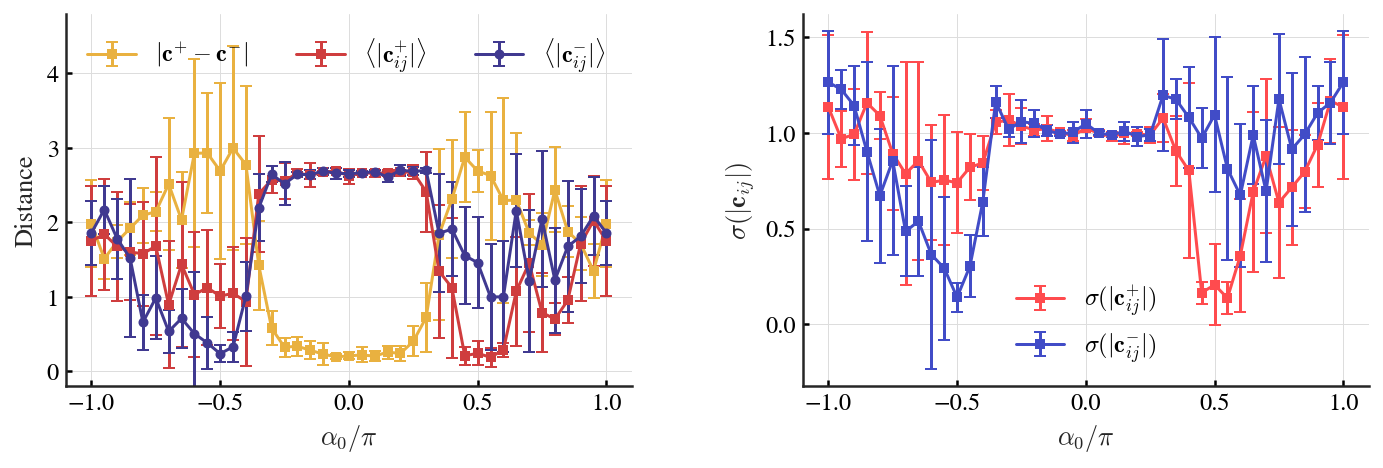

In [ ]:
# randomSeed = (8, 7, 6, 5, 4), deltaOmega = 1, boundaryLength = 7, strengthLambda = 19.2
classDistancesDf = pd.DataFrame(
    data=[tsClassDistances[sub] for sub in tsClassDistances],
    index=phaseLags, columns=randomSeeds
)
meanClassDistances = classDistancesDf.mean(axis=1)
stdSClassDistances = classDistancesDf.std(axis=1)
class1DisMeansDf = pd.DataFrame(
    data=[tsClass1DisMeans[sub] for sub in tsClass1DisMeans],
    index=phaseLags, columns=randomSeeds
)
meanClass1DisMeans = class1DisMeansDf.mean(axis=1)
stdClass1DisMeans = class1DisMeansDf.std(axis=1)
class2DisMeansDf = pd.DataFrame(
    data=[tsClass2DisMeans[sub] for sub in tsClass2DisMeans],
    index=phaseLags, columns=randomSeeds
)
meanClass2DisMeans = class2DisMeansDf.mean(axis=1)
stdClass2DisMeans = class2DisMeansDf.std(axis=1)
class1DisStdsDf = pd.DataFrame(
    data=[tsClass1DisStds[sub] for sub in tsClass1DisStds],
    index=phaseLags, columns=randomSeeds
)
meanClass1DisStds = class1DisStdsDf.mean(axis=1)
stdClass1DisStds = class1DisStdsDf.std(axis=1)
class2DisStdsDf = pd.DataFrame(
    data=[tsClass2DisStds[sub] for sub in tsClass2DisStds],
    index=phaseLags, columns=randomSeeds
)
meanClass2DisStds = class2DisStdsDf.mean(axis=1)
stdClass2DisStds = class2DisStdsDf.std(axis=1)

fig, axs = plt.subplots(1, 2, figsize=(14 * 0.7, 3.5))
ax1, ax2 = axs

stdPhaseLags = np.linspace(-1, 1, 41)
size = 4
axs[0].errorbar(stdPhaseLags, meanClassDistances, yerr=stdSClassDistances, color="#E9B140", marker='s', capsize=3, ms=size)
axs[0].errorbar(stdPhaseLags, meanClass1DisMeans, yerr=stdClass1DisMeans, color="#CF3D3E", marker='s', capsize=3, ms=size)
axs[0].errorbar(stdPhaseLags, meanClass2DisMeans, yerr=stdClass2DisMeans, color="#403990", marker='o', capsize=3, ms=size)
axs[0].legend(
    [r"$|\mathbf{c}^{+}-\mathbf{c}^{-}|$", 
     r"$\langle |\mathbf{c}^{+}_{ij}| \rangle$", 
     r"$\langle |\mathbf{c}^{-}_{ij}| \rangle$"],
    ncol=3, frameon=False, 
    loc="upper left"
)
axs[0].set_ylabel("Distance")
axs[0].set_ylim(-0.2, 4.8)

axs[1].errorbar(stdPhaseLags, meanClass1DisStds, yerr=stdClass1DisStds, color="#FF4B4E", marker='s', capsize=3, ms=size)
axs[1].errorbar(stdPhaseLags, meanClass2DisStds, yerr=stdClass2DisStds, color="#414CC7", marker='s', capsize=3, ms=size)
axs[1].legend([
    r"$\sigma(|\mathbf{c}^{+}_{ij}|)$", 
    r"$\sigma(|\mathbf{c}^{-}_{ij}|)$"
], ncol=1, loc="lower center", frameon=False)
axs[1].set_ylabel(r"$\sigma(|\mathbf{c}_{ij}|)$")

for ax in axs.flatten():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(direction='in', length=3)
    ax.grid()
    ax.set_xlabel(r"$\alpha_0/\pi$")

plt.tight_layout()
plt.savefig(f"{LOCAL_FIG_PATH}/distancesVsAlpha.pdf", bbox_inches="tight")

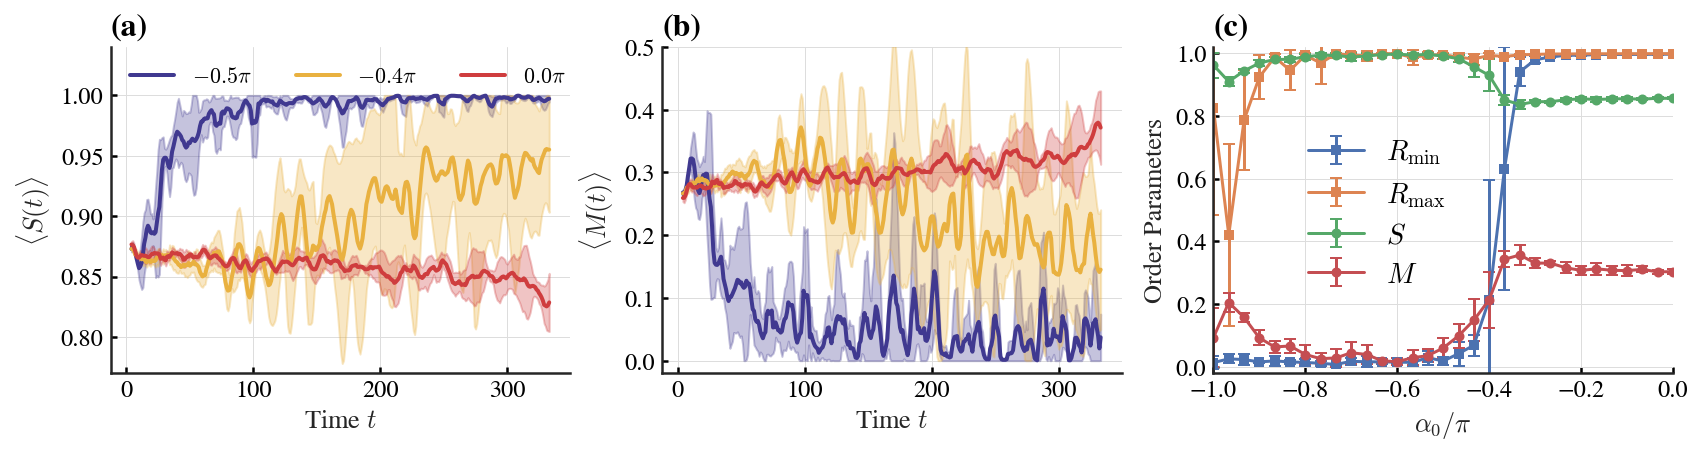

In [72]:
fig, axs = plt.subplots(1, 3, figsize=(14, 3))
axs = axs.flatten()

colors = ["#403990", "#E9B140", "#CF3D3E"]
rollingWindow = 5

for idx, phaseLag in enumerate(selectedPhaseLags[[0, 1, 5]]):
    Svalues = np.array([totalSValues[(omegaMin, phaseLag)] for omegaMin in selectedOmegaMin])
    Smax = pd.DataFrame(Svalues.T).rolling(rollingWindow).mean()
    means = Smax.mean(axis=1)
    stds = Smax.std(axis=1)
    axs[0].fill_between(Smax.index, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), alpha=0.3, color=colors[idx])
    axs[0].plot(means, color=colors[idx], lw=2, label=fr"${phaseLag / np.pi:.1f}\pi$")

    Mvalues = np.array([totalMValues[(omegaMin, phaseLag)] for omegaMin in selectedOmegaMin])
    Mmin = pd.DataFrame(Mvalues.T).rolling(rollingWindow).mean()
    means = Mmin.mean(axis=1)
    stds = Mmin.std(axis=1)
    axs[1].fill_between(Mmin.index, np.clip(means - stds, 0, 1), np.clip(means + stds, 0, 1), alpha=0.3, color=colors[idx])
    axs[1].plot(means, color=colors[idx], lw=2)

axs[0].set_ylim(0.77, 1.04)
axs[0].set_ylabel(r"$\langle S(t) \rangle$")
axs[0].set_title("(a)", loc="left", fontweight="bold", fontsize=16)
axs[0].legend(fontsize=11, ncol=3, loc="upper left", frameon=False)
axs[0].set_xlabel(r"Time $t$")

    
axs[1].set_ylim(-0.02, 0.5)
axs[1].set_ylabel(r"$\langle M(t) \rangle$")
axs[1].set_title("(b)", loc="left", fontweight="bold", fontsize=16)
axs[1].set_xlabel(r"Time $t$")

# randomSeed = (8, 7, 6, 5, 4), deltaOmega = 1, boundaryLength = 7, strengthLambda = 19.2
Sdf = pd.DataFrame(
    data=[np.mean(Ss[subS], axis=1) for subS in Ss],
    index=phaseLags, columns=randomSeeds
)
meanS = Sdf.mean(axis=1)
stdS = Sdf.std(axis=1)
Mdf = pd.DataFrame(
    data=[np.mean(Ms[subS], axis=1) for subS in Ms],
    index=phaseLags, columns=randomSeeds
)
meanM = Mdf.mean(axis=1)
stdM = Mdf.std(axis=1)
RminDf = pd.DataFrame(
    data=[Rmins[subS] for subS in Rmins],
    index=phaseLags, columns=randomSeeds
)
meanRmin = RminDf.mean(axis=1)
stdRmin = RminDf.std(axis=1)
RmaxDf = pd.DataFrame(
    data=[Rmaxs[subS] for subS in Rmaxs],
    index=phaseLags, columns=randomSeeds
)
meanRmax = RmaxDf.mean(axis=1)
stdRmax = RmaxDf.std(axis=1)

stdPhaseLags = np.linspace(-1, 0, 31)
size = 4
axs[2].errorbar(stdPhaseLags, meanRmin, yerr=stdRmin, color="C0", marker='s', label=r"$R_{\min}$", capsize=3, ms=size)
axs[2].errorbar(stdPhaseLags, meanRmax, yerr=stdRmax, color="C1", marker='s', label=r"$R_{\max}$", capsize=3, ms=size)
axs[2].errorbar(stdPhaseLags, meanS, yerr=stdS, color="C2", marker='o', label=r"$S$", capsize=3, ms=size)
axs[2].errorbar(stdPhaseLags, meanM, yerr=stdM, color="C3", marker='o', label=r"$M$", capsize=3, ms=size)

plt.legend(fontsize=14, bbox_to_anchor=(0.15, 0.8), frameon=False)
axs[2].set_ylim(-0.02, 1.02)
axs[2].set_xlim(-1, 0)
axs[2].set_ylabel("Order Parameters")
axs[2].set_title("(c)", loc="left", fontweight="bold", fontsize=16)
axs[2].set_xlabel(r"$\alpha_0/\pi$")

for ax in axs:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="in", length=3)
    ax.grid(True)

# plt.tight_layout(h_pad=-0.5)
plt.savefig(f"{LOCAL_FIG_PATH}/orderParameters.pdf", bbox_inches="tight")

In [ ]:
# randomSeed = (8, 7, 6, 5, 4), deltaOmega = 1, boundaryLength = 7, strengthLambda = 19.2
Sdf = pd.DataFrame(
    data=[np.mean(Ss[subS], axis=1) for subS in Ss],
    index=phaseLags, columns=randomSeeds
)
meanS = Sdf.mean(axis=1)
stdS = Sdf.std(axis=1)
Mdf = pd.DataFrame(
    data=[np.mean(Ms[subS], axis=1) for subS in Ms],
    index=phaseLags, columns=randomSeeds
)
meanM = Mdf.mean(axis=1)
stdM = Mdf.std(axis=1)
RminDf = pd.DataFrame(
    data=[Rmins[subS] for subS in Rmins],
    index=phaseLags, columns=randomSeeds
)
meanRmin = RminDf.mean(axis=1)
stdRmin = RminDf.std(axis=1)
RmaxDf = pd.DataFrame(
    data=[Rmaxs[subS] for subS in Rmaxs],
    index=phaseLags, columns=randomSeeds
)
meanRmax = RmaxDf.mean(axis=1)
stdRmax = RmaxDf.std(axis=1)

stdPhaseLags = np.linspace(-1, 0, 31)
size = 4
axs[2].errorbar(stdPhaseLags, meanRmin, yerr=stdRmin, color="C0", marker='s', label=r"$R_{\min}$", capsize=3, ms=size)
axs[2].errorbar(stdPhaseLags, meanRmax, yerr=stdRmax, color="C1", marker='s', label=r"$R_{\max}$", capsize=3, ms=size)
axs[2].errorbar(stdPhaseLags, meanS, yerr=stdS, color="C2", marker='o', label=r"$S$", capsize=3, ms=size)
axs[2].errorbar(stdPhaseLags, meanM, yerr=stdM, color="C3", marker='o', label=r"$M$", capsize=3, ms=size)

plt.legend(fontsize=14, bbox_to_anchor=(0.15, 0.8), frameon=False)
axs[2].set_ylim(-0.02, 1.02)
axs[2].set_xlim(-1, 0)
axs[2].set_ylabel("Order Parameters")
axs[2].set_title("(c)", loc="left", fontweight="bold", fontsize=16)
axs[2].set_xlabel(r"$\alpha_0/\pi$")

---
# Phase Diagram
Use PhaseDiagram.ipynb to generate the S, M maps csv

In [5]:
Smaps = np.mean([
    pd.read_csv(f"./tables/meanFieldOrderParameter_S_l{strengthLambda}_d{distanceD0}_dO{deltaOmega}_rS{9}.csv", index_col=0),
    pd.read_csv(f"./tables/meanFieldOrderParameter_S_l{strengthLambda}_d{distanceD0}_dO{deltaOmega}_rS{10}.csv", index_col=0)
], axis=0)
Mmaps = np.mean([
    pd.read_csv(f"./tables/meanFieldOrderParameter_M_l{strengthLambda}_d{distanceD0}_dO{deltaOmega}_rS{9}.csv", index_col=0),
    pd.read_csv(f"./tables/meanFieldOrderParameter_M_l{strengthLambda}_d{distanceD0}_dO{deltaOmega}_rS{10}.csv", index_col=0)
], axis=0)
meanOmega = omegaMins + deltaOmega / 2
deltaOmegaIJ = meanOmega * 2
minLags = np.arccos(deltaOmegaIJ / strengthLambda / 2) / np.pi

In [12]:
from scipy.optimize import fsolve

def K(minOmega: float, alpha0: float):
    d0 = 1
    L = 7
    meanFreq = minOmega + 1 / 2
    ro = 3 / meanFreq
    if d0 + 2 * (ro + d0) < L / np.sqrt(2):
        assert 0
    deltaOmegaIJ = 2 * meanFreq
    rd = L / np.sqrt(2) - 2 * ro - d0
    if (np.abs((rd ** 2) / (2 * d0 * rd)) > 1):
        return minOmega
    beta = 2 * np.arccos((rd ** 2) / (2 * d0 * rd))
    Ni = (
        (2 * beta * d0 - rd * np.sin(beta / 2)) / 
        (np.pi * d0)
    )
    return (deltaOmegaIJ / Ni) / np.cos(alpha0) - strengthLambda

def K(minOmega: float, alpha0: float):
    d0 = 1
    L = 7
    meanFreq = minOmega + 1 / 2
    ro = 3 / meanFreq
    rs = d0
    if d0 + 2 * (ro + rs) < L / np.sqrt(2):
        assert 0
    deltaOmegaIJ = 2 * meanFreq
    N = 1
    rh = L / np.sqrt(2) - 2 * (ro + rs)
    rd = rh + rs
    if (
        np.abs((d0 ** 2 + rd ** 2 - rs ** 2) / (2 * d0 * rd)) > 1 or
        np.abs((rd ** 2 + rs ** 2 - d0 ** 2) / (2 * rd * rs)) > 1
    ):
        return minOmega
    beta = 2 * np.arccos((d0 ** 2 + rd ** 2 - rs ** 2) / (2 * d0 * rd))
    alpha = 2 * np.arccos((rd ** 2 + rs ** 2 - d0 ** 2) / (2 * rd * rs))
    si = alpha * rs ** 2 / 2 + beta * d0 ** 2 / 2 - d0 * rd * np.sin(beta / 2)
    Ni = N * si / (np.pi * rs ** 2)
    return (deltaOmegaIJ / Ni) / np.cos(alpha0) - strengthLambda

solMinOmegas = list()

alpha0s = np.linspace(0, 0.49, 20) * np.pi

for alpha0 in tqdm(alpha0s):
    solMinOmega = fsolve(func=K, x0=1.7, args=(alpha0,))
    solMinOmegas.append(solMinOmega[0])

Xs = alpha0s / np.pi
Xs = np.concatenate([Xs, [0.5]])
solMinOmegas.append(0)

  0%|          | 0/20 [00:00<?, ?it/s]

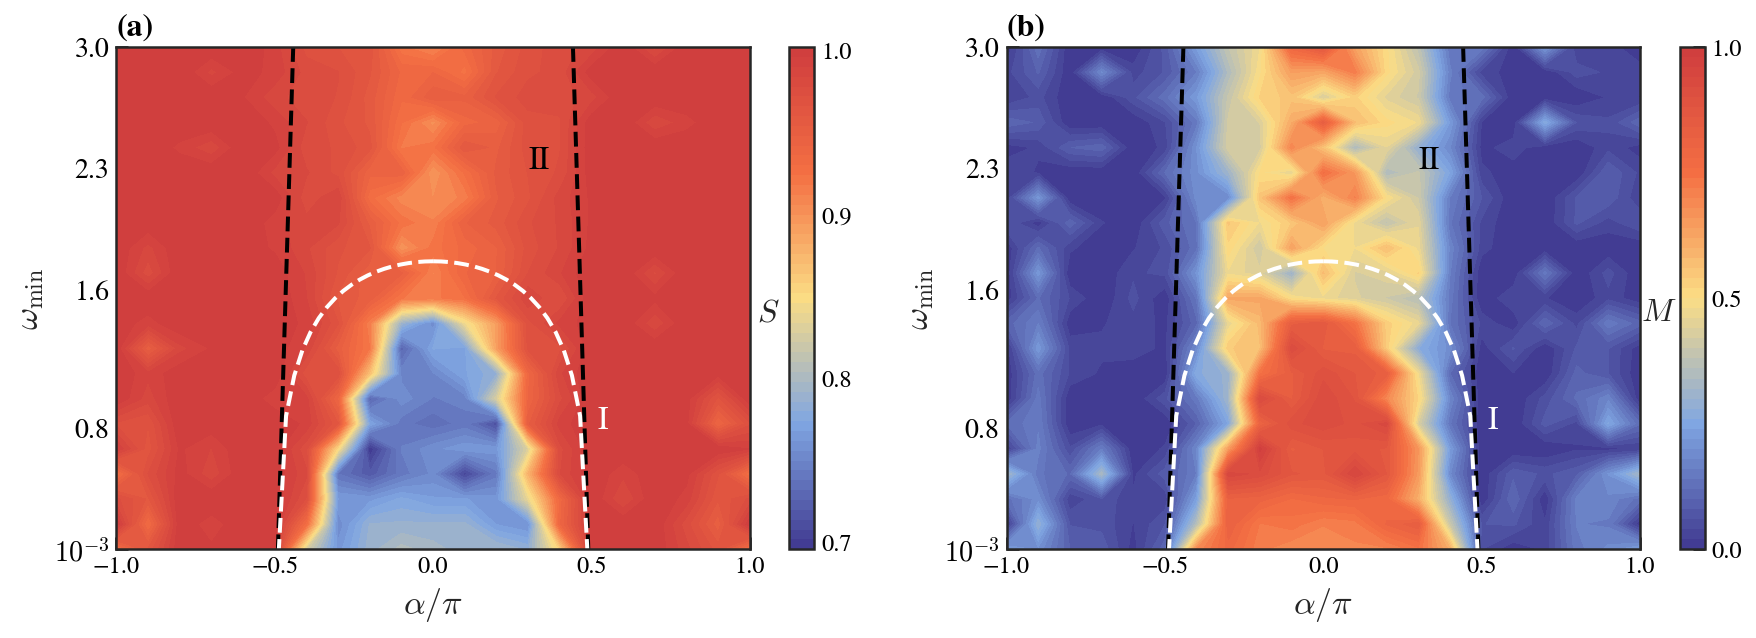

In [13]:
# deltaOmega = 1
colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors)
yLabels = np.linspace(omegaMins[0], omegaMins[-1], 5).round(1).astype(str)
yLabels[0] = r"$10^{-3}$"

fig = plt.figure(figsize=(12.8, 4.7))
ax1 = fig.add_subplot(121)
stdMaps = Smaps.copy()
stdMaps[0, 0] = 0.7
cf = plt.contourf(phaseLags / np.pi, omegaMins, stdMaps, cmap=cmap, levels=50, zorder=0)
plt.contourf(phaseLags / np.pi, omegaMins, Smaps, cmap=cmap, levels=50, zorder=1)

cbar = plt.colorbar(cf, ticks=[0.7, 0.8, 0.9, 1])
cbar.set_label(r"$S$", fontsize=16, rotation=0, labelpad=-42)
cbar.ax.tick_params(direction='in', zorder=100)
plt.title("(a)", loc="left", fontweight="bold", fontsize=16)

ax2 = fig.add_subplot(122)
stdMaps = Mmaps.copy()
stdMaps[0, 0] = 1
cf = plt.contourf(phaseLags / np.pi, omegaMins, stdMaps, cmap=cmap, levels=50, zorder=0)
plt.contourf(phaseLags / np.pi, omegaMins, Mmaps, cmap=cmap, levels=50, zorder=1)

cbar = plt.colorbar(cf, ticks=[0, 0.5, 1])
cbar.set_label(r"$M$", fontsize=16, rotation=0, labelpad=-42)
cbar.ax.tick_params(direction='in', zorder=100)
plt.title("(b)", loc="left", fontweight="bold", fontsize=16)

for ax in [ax1, ax2]:
    ax.plot(minLags, omegaMins, color="black", linestyle="--", lw=2, zorder=2)
    ax.plot(-minLags, omegaMins, color="black", linestyle="--", lw=2, zorder=2)
    ax.plot(Xs, solMinOmegas, color="white", linestyle="--", lw=2, zorder=2)
    ax.plot(-Xs, solMinOmegas, color="white", linestyle="--", lw=2, zorder=2)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1], fontsize=14)
    ax.set_yticks(np.linspace(omegaMins[0], omegaMins[-1], 5).round(1), yLabels, fontsize=14)
    ax.set_xlabel(r"$\alpha/\pi$", fontsize=17)
    ax.set_ylabel(r"$\omega_{\min}$", fontsize=17)
    ax.tick_params(direction='in', length=6, zorder=100)
    ax.set_ylim(0.1, 3)
    ax.text(0.52, 0.8, "I", fontsize=16, color="white")
    ax.text(0.3, 2.3, "II", fontsize=16, color="black")

plt.tight_layout()
plt.savefig(f"{LOCAL_FIG_PATH}/phaseDiagram.png", bbox_inches="tight", dpi=300)

In [14]:
LOCAL_FIG_PATH

'./PCT_C_figs'

In [16]:
Xs = np.linspace(0, 0.49, 10)
Xs = np.concatenate([Xs, [0.5]])

array([0.        , 0.05444444, 0.10888889, 0.16333333, 0.21777778,
       0.27222222, 0.32666667, 0.38111111, 0.43555556, 0.49      ,
       0.5       ])

(0.1, 3.0)

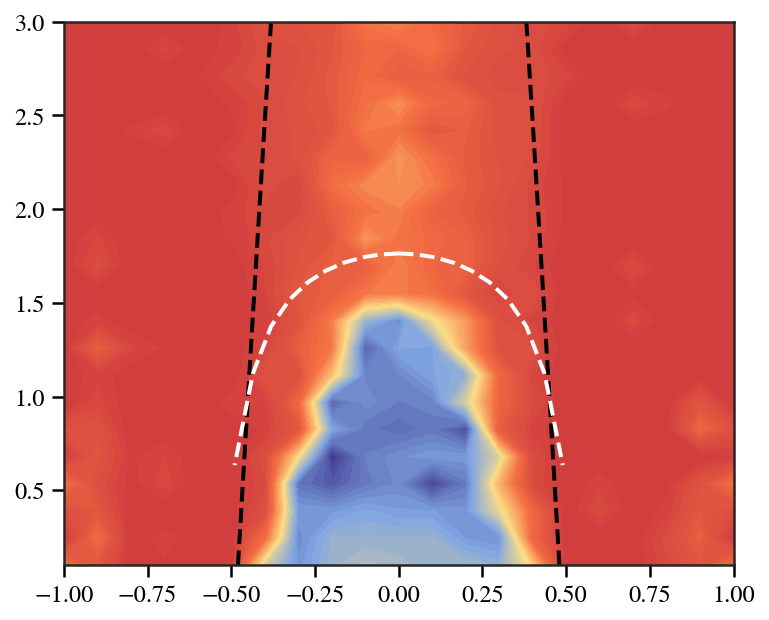

In [85]:
meanOmega = omegaMins + deltaOmega / 2
deltaOmegaIJ = meanOmega * 2
minLags = np.arccos(deltaOmegaIJ / strengthLambda) / np.pi

plt.contourf(phaseLags / np.pi, omegaMins, Smaps, cmap=cmap, levels=50, zorder=1)

plt.plot(minLags, omegaMins, color="black", linestyle="--", lw=2, zorder=2)
plt.plot(-minLags, omegaMins, color="black", linestyle="--", lw=2, zorder=2)

plt.plot(np.linspace(0, 0.49, 10), solMinOmegas, color="white", linestyle="--", lw=2, zorder=2)
plt.plot(-np.linspace(0, 0.49, 10), solMinOmegas, color="white", linestyle="--", lw=2, zorder=2)
plt.xlim(-1, 1)
plt.ylim(0.1, 3)

---
# Sync Problem Order Parameters

In [73]:
omegaMins = [0.1]  # np.linspace(0.1, 0.5, 30)
phaseLags = np.linspace(-1, 1, 51) * np.pi
randomSeed = 10

strengthLambda = 0.15 * 32 * 2 * 2
deltaOmega = 1
agentsNum = 1000

halfAgentsNum = agentsNum // 2

SAVE_PATH = "./data"  # r"E:\MS_ExperimentData\general"

models = [
    PurePhaseModel(
        strengthLambda=strengthLambda, phaseLag=phaseLag, 
        distribution="uniform", # initPhaseTheta=np.zeros(1000),
        agentsNum=1000, omegaMin=omegaMin, deltaOmega=deltaOmega,
        savePath=SAVE_PATH, dt=0.01,
        tqdm=True, overWrite=True, randomSeed=randomSeed
    )
    for omegaMin in omegaMins
    for phaseLag in phaseLags
]

rawClass1, rawClass2 = (
    models[0].omegaTheta < 0,
    models[0].omegaTheta >= 0
)

In [74]:
Rmins = dict()
Rmaxs = dict()
Rs = dict()
RsC1 = dict()
RsC1Max = dict()
RsC1Min = dict()
RsC2 = dict()
RsC2Max = dict()
RsC2Min = dict()
effPointTheta = dict()
tailPhi = dict()

for model in tqdm(models):
    targetPath = f"{model.savePath}/{model}.h5"
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

    TNum = totalPhaseTheta.shape[0] // model.agentsNum
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    
    singleRs = (
        np.mean(np.sin(totalPhaseTheta), axis=1) ** 2 + 
        np.mean(np.cos(totalPhaseTheta), axis=1) ** 2
    ) ** 0.5
    signleRsC1 = (
        np.mean(np.sin(totalPhaseTheta[:, rawClass1]), axis=1) ** 2 + 
        np.mean(np.cos(totalPhaseTheta[:, rawClass1]), axis=1) ** 2
    ) ** 0.5
    signleRsC2 = (
        np.mean(np.sin(totalPhaseTheta[:, rawClass2]), axis=1) ** 2 + 
        np.mean(np.cos(totalPhaseTheta[:, rawClass2]), axis=1) ** 2
    ) ** 0.5

    tailSingleRs = singleRs[-100:]
    tailSingleRsC1 = signleRsC1[-100:]
    tailSingleRsC2 = signleRsC2[-100:]
    Rmins[model.phaseLag] = tailSingleRs.min()
    Rmaxs[model.phaseLag] = tailSingleRs.max()
    Rs[model.phaseLag] = singleRs[-1]
    RsC1[model.phaseLag] = signleRsC1[-1]
    RsC1Max[model.phaseLag] = tailSingleRsC1.max()
    RsC1Min[model.phaseLag] = tailSingleRsC1.min()
    RsC2[model.phaseLag] = signleRsC2[-1]
    RsC2Max[model.phaseLag] = tailSingleRsC2.max()
    RsC2Min[model.phaseLag] = tailSingleRsC2.min()
    effPointTheta[model.phaseLag] = totalPointTheta[-100:].mean(axis=0)
    tailPhi[model.phaseLag] = (
        totalPhaseTheta[-100:, rawClass2].mean(axis=1) - 
        totalPhaseTheta[-100:, rawClass1].mean(axis=1)
    )

  0%|          | 0/51 [00:00<?, ?it/s]

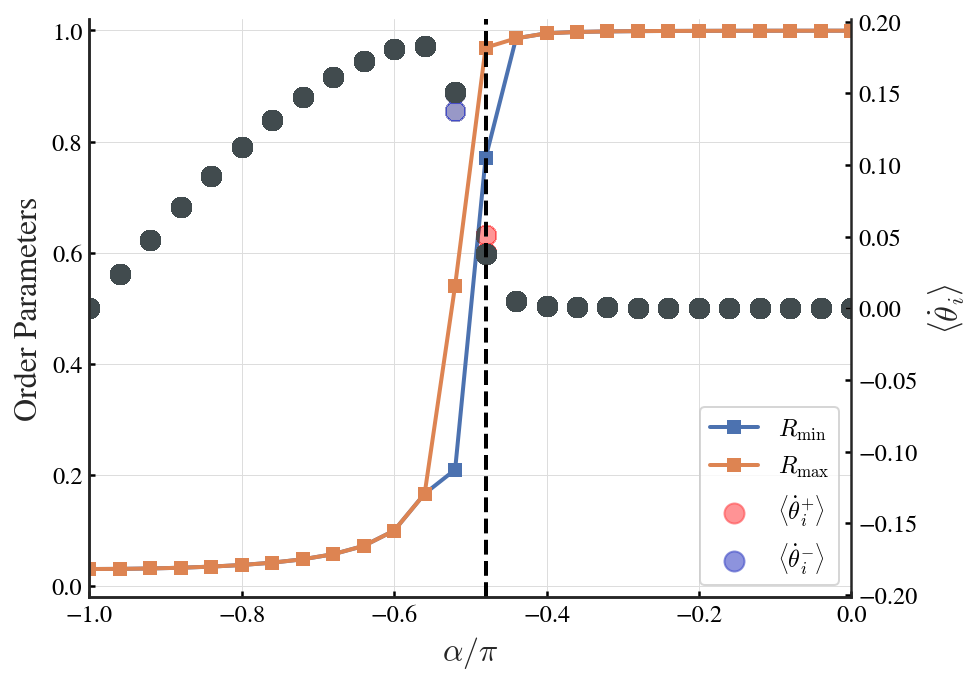

In [82]:
# deltaOmega = 1
meanOmega = 0.1 + 1 / 2
deltaOmegaIJ = meanOmega * 2
minLags = np.arccos(deltaOmegaIJ / strengthLambda) / np.pi

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

alpha = 1
yShift = 0.02

ax1.plot(phaseLags / np.pi, Rmins.values(), label=r"$R_{\min}$", color="C0", marker='s', alpha=alpha, lw=2)
ax1.plot(phaseLags / np.pi, Rmaxs.values(), label=r"$R_{\max}$", color="C1", marker='s', alpha=alpha, lw=2)
alpha = 0.6
ax1.scatter(-1, -1, color="#FF4B4E", s=100, label=r"$\left< \dot{\theta}_i^{+} \right>$", alpha=alpha)
ax1.scatter(-1, -1, color="#414CC7", s=100, label=r"$\left< \dot{\theta}_i^{-} \right>$", alpha=alpha)

for ax in [ax1]:
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_ylim(-yShift, 1 + yShift)
    ax.set_xlim(-1, 1)
    ax.legend(loc="lower right")
    ax.tick_params(direction='in', length=3)
    ax.axvline(minLags, color="black", linestyle="--", lw=2)
    ax.axvline(-minLags, color="black", linestyle="--", lw=2)
    ax.set_xlabel(r"$\alpha/\pi$", fontsize=16)
    ax.set_ylabel(r"Order Parameters", fontsize=16)
    ax.grid(True)

ax11 = ax1.twinx()
for phaseLag in phaseLags:
    ax11.scatter(np.ones(500) * phaseLag / np.pi, effPointTheta[phaseLag][:500], alpha=0.003, 
                 color="#FF4B4E", s=100)
    ax11.scatter(np.ones(500) * phaseLag / np.pi, effPointTheta[phaseLag][500:], alpha=0.003, 
                 color="#414CC7", s=100)
ax11.tick_params(direction='in', length=3)
ax11.set_ylabel(r"$\left< \dot{\theta}_i \right>$", fontsize=16)
ax11.spines['top'].set_color('none')


plt.xlim(-1, 0)
plt.tight_layout()
plt.savefig(f"./{LOCAL_FIG_PATH}/SyncOPsAndRealFreq.png", bbox_inches="tight", dpi=300)